# Estimation of population parameters


The objective of this tutorial is illustrate the use of the *samplics* estimation APIs. There are two main classes: *TaylorEstimator* and *ReplicateEstimator*. The former class uses linearization methods to estimate variance of population parameters while the latter uses replicate-based methods (bootstrap, brr/fay, and jackknife) to estimate the variance. 

In [2]:
from IPython.core.display import Image, display

import numpy as np
import pandas as pd

import samplics 
from samplics.datasets import Nhanes2, Nhanes2brr, Nhanes2jk, Nmihs
from samplics.estimation import TaylorEstimator, ReplicateEstimator

## Taylor approximation <a name="section1"></a>

In [4]:
# Load Nhanes sample data
nhanes2_cls = Nhanes2()
nhanes2_cls.load_data()
nhanes2 = nhanes2_cls.data

nhanes2.head(15)

,stratid,psuid,race,highbp,highlead,diabetes,finalwgt
0,1,1,1,0,NaN,0.0,8995
1,1,1,1,0,0.0,0.0,25964
2,1,1,3,0,NaN,0.0,8752
3,1,1,1,1,NaN,1.0,4310
4,1,1,1,0,0.0,0.0,9011
5,1,1,1,1,NaN,0.0,4310
6,1,1,1,0,0.0,0.0,3201
7,1,1,1,1,NaN,0.0,25386
8,1,1,1,0,NaN,0.0,12102
9,1,1,2,0,0.0,0.0,4312


We calculate the survey mean of the level of zinc using Stata and we get the following    

Using *samplics*, the same estimate can be obtained using the snippet of code below.

In [6]:
zinc_mean_str = TaylorEstimator("mean")
zinc_mean_str.estimate(
    y=nhanes2["zinc"],
    samp_weight=nhanes2["finalwgt"],
    stratum=nhanes2["stratid"],
    psu=nhanes2["psuid"],
    remove_nan=True,
)

print(zinc_mean_str)

KeyError: 'zinc'


Let's remove the stratum parameter then we get the following with stata        

with samplics, we get ...

In [6]:
zinc_mean_nostr = TaylorEstimator("mean")
zinc_mean_nostr.estimate(
    y=nhanes2f["zinc"], samp_weight=nhanes2f["finalwgt"], psu=nhanes2f["psuid"], remove_nan=True
)

print(zinc_mean_nostr)

SAMPLICS - Estimation of Mean

Number of strata: 1
Number of psus: 2
Degree of freedom: 1

      MEAN        SE        LCI        UCI        CV
 87.182067  0.742622  77.746158  96.617976  0.008518



The other parameters currently implemented in *TaylorEstimator* are TOTAL, PROPORTION and RATIO. TOTAL and PROPORTION have the same function call as the MEAN parameter. For the RATIO parameter, it is necessary to provide the parameter *x*.         

In [8]:
ratio_bp_lead = TaylorEstimator("ratio")
ratio_bp_lead.estimate(
    y=nhanes2f["highbp"],
    samp_weight=nhanes2f["finalwgt"],
    x=nhanes2f["highlead"],
    stratum=nhanes2f["stratid"],
    psu=nhanes2f["psuid"],
    remove_nan=True,
)

print(ratio_bp_lead)

SAMPLICS - Estimation of Ratio

Number of strata: 31
Number of psus: 62
Degree of freedom: 31

   RATIO        SE      LCI       UCI        CV
 5.93255  0.553058  4.80458  7.060519  0.093224


## Replicate-based variance estimation <a name="section2"></a>

#### Bootstrap  <a name="section21"></a>

In [9]:
nmihs_bs = pd.read_csv("../../../datasets/docs/nmihs_bs.csv")

nmihs_bs.describe()

,idnum,finwgt,scale,wgtstr,fsr,marital,age,race,highbp,vagbleed,...,bsrw991,bsrw992,bsrw993,bsrw994,bsrw995,bsrw996,bsrw997,bsrw998,bsrw999,bsrw1000
count,9.953000e+03,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,...,9953.000000,9953.00000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000
mean,1.249782e+07,391.733348,1.000000,1412.713453,1.066010,0.589671,25.611574,0.525068,0.059781,0.056465,...,391.181948,391.43303,391.796894,391.703743,391.241160,391.591024,392.410848,390.743198,391.172844,391.374216
std,1.468522e+06,382.161305,0.975565,166.653606,0.248312,0.491918,5.784969,0.499396,0.237093,0.230830,...,665.617353,661.07383,666.929639,657.896328,664.270824,660.660033,674.418284,657.544689,666.867503,658.914238
min,1.010002e+07,18.406610,0.046990,1111.000000,1.000000,0.000000,15.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.110273e+07,149.956650,0.382800,1313.000000,1.000000,0.000000,21.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.240030e+07,167.160800,0.426720,1324.000000,1.000000,1.000000,25.000000,1.000000,0.000000,0.000000,...,143.480290,149.59361,149.998520,149.998520,149.593610,149.998520,149.593610,149.998520,149.593610,149.998520
75%,1.370347e+07,882.657940,2.253210,1612.000000,1.000000,1.000000,30.000000,1.000000,0.000000,0.000000,...,422.964510,449.99557,422.964510,439.504430,422.964510,449.995570,402.811830,422.964510,422.964510,431.914610
max,1.520015e+07,1228.653470,3.136450,1624.000000,2.000000,1.000000,46.000000,1.000000,1.000000,1.000000,...,5769.781700,7374.15330,6145.127900,5491.954100,5123.111800,5769.781700,5814.420400,5123.111800,5568.022900,6145.127900



Let's estimate the average birth weight using the bootstrap weights. From Stata, we get 

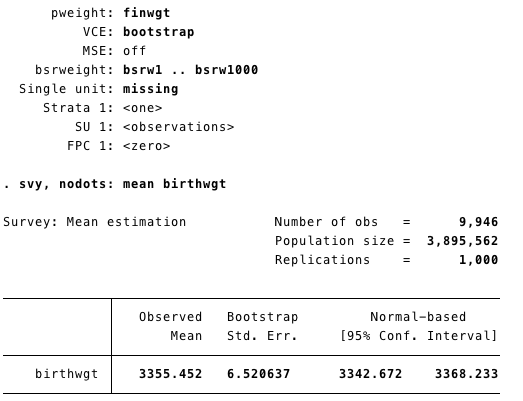

In [10]:
Image(filename="mean_birthwgt_bs.png")

Using *samplics*, we obtain ...

In [11]:
# rep_wgt_boot = nmihsboot.loc[:, "bsrw1":"bsrw1000"]

birthwgt = ReplicateEstimator("bootstrap", "mean").estimate(
    y=nmihs_bs["birthwgt"],
    samp_weight=nmihs_bs["finwgt"],
    rep_weights=nmihs_bs.loc[:, "bsrw1":"bsrw1000"],
    remove_nan=True,
)

print(birthwgt)

SAMPLICS - Estimation of Mean

Number of strata: None
Number of psus: None
Degree of freedom: 999

        MEAN        SE          LCI          UCI        CV
 3355.452419  6.520638  3342.656702  3368.248137  0.001943


#### Balanced repeated replication (BRR)  <a name="section22"></a>

In [12]:
nhanes2brr = pd.read_csv("../../../datasets/docs/nhanes2brr.csv")

nhanes2brr.describe()

,sampl,region,smsa,location,houssiz,sex,race,age,height,weight,...,brr_23,brr_24,brr_25,brr_26,brr_27,brr_28,brr_29,brr_30,brr_31,brr_32
count,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,...,10351.000000,10351.000000,10351.000000,10351.000000,10351.00000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000
mean,33625.572795,2.580910,2.655975,33.065501,2.943774,1.525167,1.143561,47.579654,167.650876,71.897521,...,11406.227031,11539.930248,11387.076031,11321.057096,11384.75954,11162.040383,11338.245194,11381.763888,11446.294851,11941.538402
std,18412.277368,1.075327,1.282432,18.412539,1.695156,0.499390,0.402008,17.214829,9.655916,15.356417,...,15160.287612,15831.644617,15719.924320,15328.882339,15457.87036,14878.705816,14902.358162,15411.507507,15268.155884,15674.048108
min,1400.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000,135.500000,30.840000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17402.500000,2.000000,1.000000,17.000000,2.000000,1.000000,1.000000,31.000000,160.500000,60.669998,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34678.000000,3.000000,2.000000,34.000000,2.000000,2.000000,1.000000,49.000000,167.297000,70.419998,...,5962.000000,0.000000,0.000000,4678.000000,4440.00000,4158.000000,5722.000000,5534.000000,5094.000000,6202.000000
75%,49435.500000,4.000000,4.000000,49.000000,4.000000,2.000000,1.000000,63.000000,174.598010,81.190002,...,19094.000000,19818.000000,18024.000000,18235.000000,19106.00000,19038.000000,18878.000000,18786.000000,19148.000000,20070.000000
max,64709.000000,4.000000,4.000000,64.000000,14.000000,2.000000,3.000000,74.000000,200.000000,175.880000,...,116348.000000,159268.000000,159268.000000,116348.000000,159268.00000,123068.000000,116348.000000,159268.000000,123068.000000,159268.000000



Let's estimate the ratio of weight over height using the brr weights. From Stata, we get 

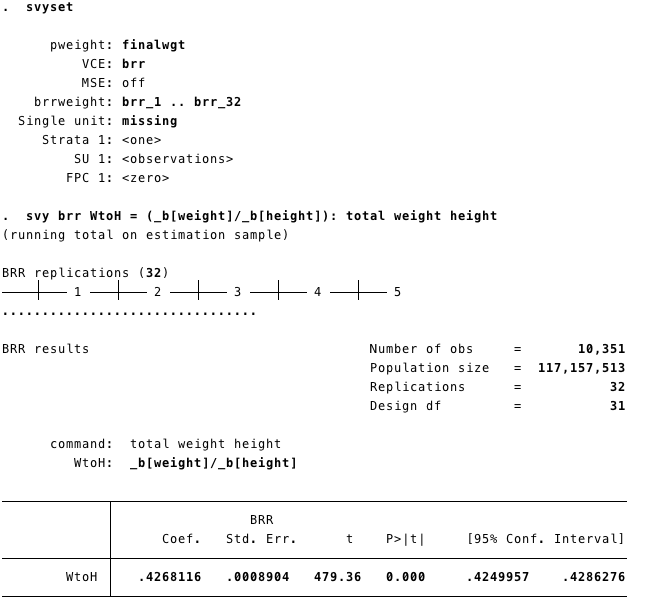

In [13]:
Image(filename="ratio_weight_height_brr.png")

In [14]:
brr = ReplicateEstimator("brr", "ratio")

ratio_wgt_hgt = brr.estimate(
    y=nhanes2brr["weight"],
    samp_weight=nhanes2brr["finalwgt"],
    x=nhanes2brr["height"],
    rep_weights=nhanes2brr.loc[:, "brr_1":"brr_32"],
    remove_nan=True,
)

print(ratio_wgt_hgt)

SAMPLICS - Estimation of Ratio

Number of strata: None
Number of psus: None
Degree of freedom: 16

    RATIO       SE       LCI       UCI        CV
 0.426812  0.00089  0.424924  0.428699  0.002086


#### Jackknife  <a name="section23"></a>

In [15]:
nhanes2jknife = pd.read_csv("../../../datasets/docs/nhanes2jknife.csv")

nhanes2jknife.describe()

,sampl,region,smsa,location,houssiz,sex,race,age,height,weight,...,jkw_53,jkw_54,jkw_55,jkw_56,jkw_57,jkw_58,jkw_59,jkw_60,jkw_61,jkw_62
count,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,...,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000
mean,33625.572795,2.580910,2.655975,33.065501,2.943774,1.525167,1.143561,47.579654,167.650876,71.897521,...,11275.300454,11361.645348,11236.757318,11400.188484,11322.798763,11314.147039,11324.355811,11312.589991,11296.868032,11340.077770
std,18412.277368,1.075327,1.282432,18.412539,1.695156,0.499390,0.402008,17.214829,9.655916,15.356417,...,7625.499536,8339.543004,7514.537230,7561.024713,7658.592794,7603.812786,7581.347187,7599.151634,7531.612336,7524.992924
min,1400.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000,135.500000,30.840000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17402.500000,2.000000,1.000000,17.000000,2.000000,1.000000,1.000000,31.000000,160.500000,60.669998,...,6107.000000,6063.500000,5986.500000,6279.000000,6145.500000,6078.000000,6109.500000,6062.500000,6006.000000,6078.000000
50%,34678.000000,3.000000,2.000000,34.000000,2.000000,2.000000,1.000000,49.000000,167.297000,70.419998,...,9206.000000,9172.000000,9333.000000,9333.000000,9252.000000,9261.000000,9324.000000,9270.000000,9301.000000,9359.000000
75%,49435.500000,4.000000,4.000000,49.000000,4.000000,2.000000,1.000000,63.000000,174.598010,81.190002,...,14851.000000,14851.000000,15063.000000,15214.500000,15122.000000,15104.000000,14929.500000,14923.500000,15297.500000,15257.500000
max,64709.000000,4.000000,4.000000,64.000000,14.000000,2.000000,3.000000,74.000000,200.000000,175.880000,...,61538.000000,159268.000000,79634.000000,79634.000000,98370.000000,79634.000000,114332.000000,79634.000000,79634.000000,79634.000000



Let's estimate the ratio of weight over height using the brr weights. From Stata, we get 

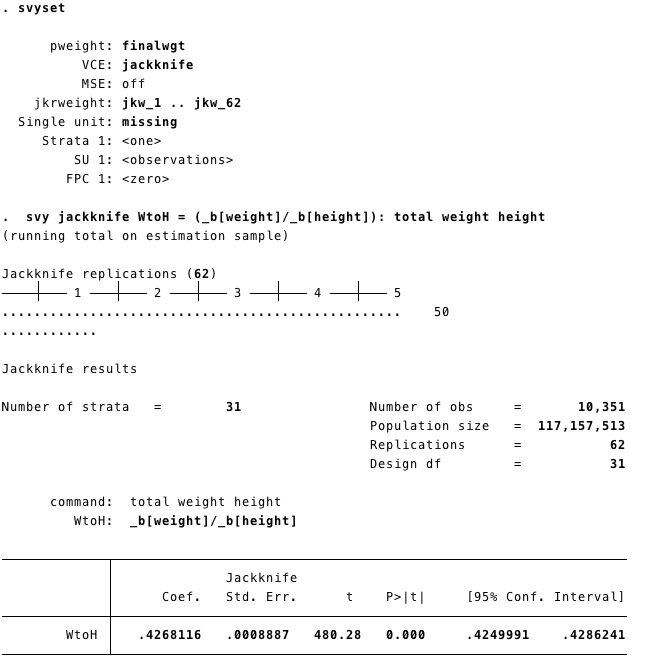

In [16]:
Image(filename="ratio_weight_height_jknife.png")

In this case, stratification was used to calculate the jackknife weights. The stratum variable is not indicated in the dataset or survey design description. However, it says that the number of strata is 31 and the number of replicates is 62. Hence, the jackknife replicate coefficient is $(n_h - 1) / n_h = (2-1) / 2 = 0.5$. Now we can call *replicate()* and specify *rep_coefs = 0.5*.

In [17]:
jackknife = ReplicateEstimator("jackknife", "ratio")

ratio_wgt_hgt2 = jackknife.estimate(
    y=nhanes2jknife["weight"],
    samp_weight=nhanes2jknife["finalwgt"],
    x=nhanes2jknife["height"],
    rep_weights=nhanes2jknife.loc[:, "jkw_1":"jkw_62"],
    rep_coefs=0.5,
    remove_nan=True,
)

print(ratio_wgt_hgt2)

SAMPLICS - Estimation of Ratio

Number of strata: None
Number of psus: None
Degree of freedom: 61

    RATIO        SE       LCI       UCI        CV
 0.426812  0.000889  0.425035  0.428589  0.002082
